In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yahooFinance
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

## Load Dataset

In [7]:
AAPL_data = yahooFinance.download('AAPL', start='2010-01-01', end='2023-01-01')
AAPL_data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.461977,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.473149,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.370186,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.358407,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.400681,447610800
...,...,...,...,...,...,...
2022-12-23,130.919998,132.419998,129.639999,131.860001,130.782562,63814900
2022-12-27,131.380005,131.410004,128.720001,130.029999,128.967514,69007800
2022-12-28,129.669998,131.029999,125.870003,126.040001,125.010117,85438400


In [11]:
AAPL_data_close = AAPL_data[['Close']]
AAPL_data_close

,Close
Date,
2010-01-04,7.643214
2010-01-05,7.656429
2010-01-06,7.534643
2010-01-07,7.520714
2010-01-08,7.570714
...,...
2022-12-23,131.860001
2022-12-27,130.029999
2022-12-28,126.040001


# Pre-process Data

### Data should be scaled from 0 to 1 for our RNN model

In [12]:
scaler =MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(AAPL_data_close)

In [14]:
# Create a function to make sequences of 60 days for training and testing
def sequences(data, seq_length):
    inputs, targets = [], []

    for i in range(len(data) - seq_length):
        inputs.append(data[i: i + seq_length])
        targets.append(data[i + seq_length])
    
    return np.array(inputs), np.array(targets)

In [15]:
# Here we split our data 80:20
seq_length = 60
X, y = sequences(data_scaled, seq_length)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [28]:
# We must make sure our input data (X) is in 3D shape for our LSTM layers
# But don't reshape the target (y) because it is the output we are looking for and it just 1 value
X.shape

(3212, 60, 1)

# Building our RNN Model

In [16]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),       # input_shape should be (time steps, features)... and return_sequences=True because we are using another LSTM layer
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

c:\Users\Raj\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [33]:
# For regression tasks, don't use accuracy as a metric. Always use loss functions to evaluate in a regression model
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
history = model.fit(X_train, y_train, batch_size=32, epochs=25, validation_data=(X_test, y_test))

Epoch 1/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.0060 - val_loss: 0.0161
Epoch 2/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0025 - val_loss: 0.0127
Epoch 3/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0024 - val_loss: 0.0127
Epoch 4/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0039 - val_loss: 0.0200
Epoch 5/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0026 - val_loss: 0.0125
Epoch 6/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0025 - val_loss: 0.0225
Epoch 7/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0028 - val_loss: 0.0140
Epoch 8/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0030 - val_loss: 0.0154
Epoch 9/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0028 - val_loss: 0.0127
Epoch 10/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0025 - val_loss: 0.0125
Epoch 11/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0025 - val_loss: 0.0152
Epoch 12/25
81/81 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0

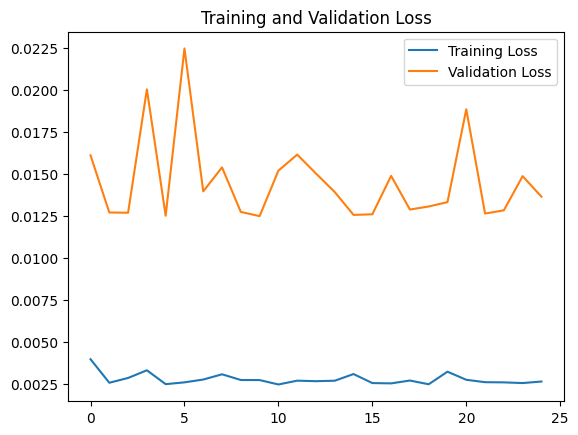

In [37]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [42]:
predictions = model.predict(X_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [46]:
# Inverse the predictions back to the normal format using the same scaler as before (convert to 2D)
predictions = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test)

In [62]:
len(AAPL_data_close)

3272

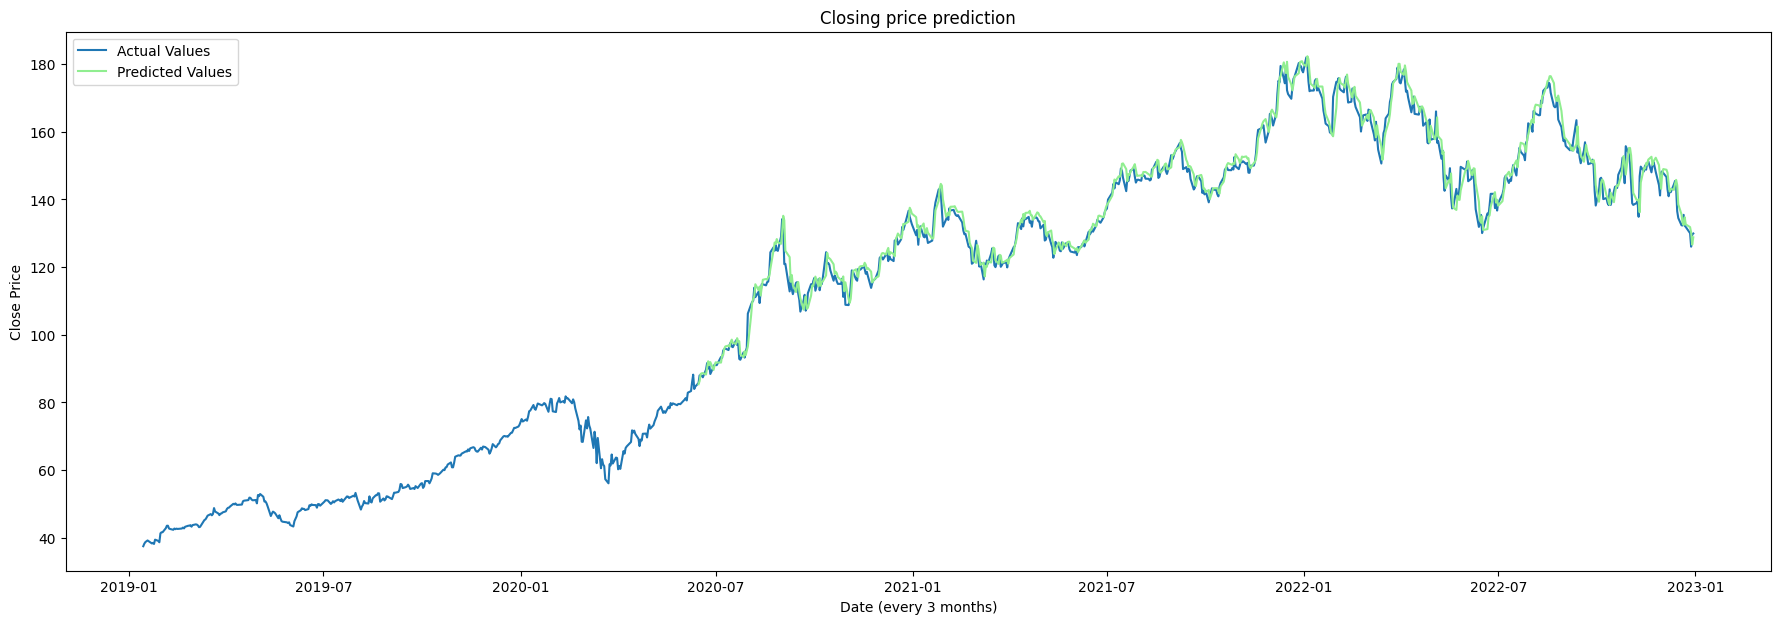

In [78]:
plt.figure(figsize=(22, 7))
plt.plot(AAPL_data_close.index[2272:], AAPL_data_close[2272:], label='Actual Values')
plt.plot(AAPL_data_close.index[-len(y_test):], predictions, label='Predicted Values', color='lightgreen')
plt.title('Closing price prediction')
plt.xlabel('Date (every 3 months)')
plt.ylabel('Close Price')
plt.legend(loc='upper left')
plt.show()